# Problem Statement:

The problem statement is to analyze the relationship between IMDb ratings and worldwide gross revenue for movies in a given normalized database. The analysis aims to provide insights into how the IMDb ratings of movies correlate with their financial success, as measured by gross worldwide revenue.

In [ ]:
# import sqlite3
def convert_to_float(value):
    try:
        # Check if the value is not None and not an empty string
        if value is not None and value != "":
            return float(value)
        else:
            return 0
    except ValueError:
        # If the value cannot be converted to float, return None or handle the exception as needed
        return 0
def parse_csv_line(line):
    result = []
    field = ''
    in_quotes = False

    for char in line:
        if char == '"':
            in_quotes = not in_quotes
        elif char == ',' and not in_quotes:
            result.append(field)
            field = ''
        else:
            field += char

    # Add the last field
    result.append(field)

    return result

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def parse_csv_denormalized_db(file_path):
    # Establish a connection to the SQLite database
    conn = create_connection('denormalized.db')
    cursor = conn.cursor()
    with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
         # Read the first line to get headers
        headers = parse_csv_line(file.readline())

        # Create a table with columns based on CSV headers
        columns = ', '.join([f'"{header}" TEXT' for header in headers])
        cursor.execute(f'CREATE TABLE IF NOT EXISTS Denormalized ({columns})')
        

        with conn:
            for line in file:
                # Parse each line into a list of values
                row = parse_csv_line(line)
                sql = f"INSERT INTO Denormalized VALUES ({', '.join('?' * len(row))})"
                cursor.execute(sql, tuple(row))
    #Commit changes and close the connection
    conn.commit()
    conn.close()
        

def apply_normalization(denormalized_db_file_name):
    # Connect to the denormalized database
    conn_denormalized = create_connection(denormalized_db_file_name)
    cursor_denormalized = conn_denormalized.cursor()
    # Connect to the new normalized database
    conn_normalized = create_connection('normalized.db')
    cursor_normalized = conn_normalized.cursor()

    cursor_normalized.execute('''
    CREATE TABLE if not exists Movie (
        MovieId integer not null PRIMARY KEY,
        Title TEXT not null,
        Summary TEXT,
        MainGenres TEXT,
        Rating TEXT,
        ReleaseYear integer,
        Runtime float(1),
        ImdbRating float(1),
        NumberOfRatings float(1),
        DirectorId integer,
        WritersId integer,
        FinancialsId integer
    )
    ''')

    cursor_normalized.execute('''
    CREATE TABLE if not exists Director (
        DirectorId integer not null primary key,
        Director TEXT
    )
    ''')
    
    cursor_normalized.execute('''
    CREATE TABLE if not exists Writers (
        WritersId integer not null primary key,
        Writer TEXT
    )
    ''')

    cursor_normalized.execute('''
    CREATE TABLE if not exists Financials (
        FinancialsId integer not null primary key,
        Budget float(1),
        GrossUsCanada float(3),
        GrossWorldWide float(3),
        OpeningWeekend Text,
        GrossOpeningWeekend float(3)
    )
    ''')
    
    cursor_denormalized.execute("SELECT * from Denormalized")
    rows = cursor_denormalized.fetchall()
    # Insert data into the normalized tables
    for row in rows:
        # Mapping data to the Director table
        cursor_normalized.execute('SELECT DirectorId FROM Director WHERE Director = ?', (row[2],))
        director_record = cursor_normalized.fetchone()
        if not director_record:
            cursor_normalized.execute('INSERT INTO Director (Director) VALUES (?)', (row[2],))
            director_id = cursor_normalized.lastrowid
        else:
            director_id = director_record[0]

        # Mapping data to the Writers table
        cursor_normalized.execute('SELECT WritersId FROM Writers WHERE Writer = ?', (row[3],))
        writers_record = cursor_normalized.fetchone()
        if not writers_record:
            cursor_normalized.execute('INSERT INTO Writers (Writer) VALUES (?)', (row[3],))
            writers_id = cursor_normalized.lastrowid
        else:
            writers_id = writers_record[0]
        
        # Mapping data to the Financials table
        cursor_normalized.execute('''
            INSERT INTO Financials (Budget, GrossUsCanada, GrossWorldWide, OpeningWeekend, GrossOpeningWeekend)
            VALUES (?, ?, ?, ?, ?)
        ''', (row[10], row[11], row[12], row[13], row[14]))
        
        financials_id = cursor_normalized.lastrowid
        
        # Mapping data to the Movie table
        cursor_normalized.execute('''
            INSERT INTO Movie (Title, Summary, MainGenres, Rating, ReleaseYear, Runtime, ImdbRating, NumberOfRatings, DirectorId, WritersId, FinancialsId)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (row[0], row[1], row[4], row[5], int(convert_to_float(row[6])), convert_to_float(row[7]), convert_to_float(row[8]), convert_to_float(row[9]), director_id, writers_id, financials_id))


    # Commit changes to the normalized database
    conn_normalized.commit()

    # Close both database connections
    conn_denormalized.close()
    conn_normalized.close()

file_path = './IMDbMovies-Clean.csv'
parse_csv_denormalized_db(file_path)
apply_normalization('denormalized.db')



### CSV Parsing and Denormalized Database Creation:

Reads a CSV file containing information about movies (./IMDbMovies-Clean.csv) and parses each line of the CSV file into fields using a custom CSV parsing function (parse_csv_line).

Creates an SQLite database (denormalized.db) and a table named "Denormalized" based on the parsed CSV headers and inserts each row from the CSV file into the "Denormalized" table.


### Data Normalization:

Connects to both the denormalized database (denormalized.db) and a new normalized database (normalized.db).

Defines normalized tables (Movie, Director, Writers, and Financials) in the normalized database.

Reads data from the "Denormalized" table and maps it to corresponding tables in the normalized database.

Handles relationships between tables using foreign keys and inserts the normalized data into the appropriate tables.

In [2]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Output
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('normalized.db')

# Read tables into pandas DataFrames
movies_df = pd.read_sql_query("SELECT * FROM Movie", conn)

conn.close()

# Dropdown for selecting a genre
filtered_genres = movies_df['MainGenres'].dropna().unique()
filtered_genres = [genre for genre in filtered_genres if genre.strip()]  # Removes genres that are empty strings
options_data =['All'] + sorted(filtered_genres)
genre_dropdown = widgets.Dropdown(
    options=options_data,
    value='All',
    description='Genre:',
)

# Dropdown for selecting a year
filtered_years = [year for year in movies_df['ReleaseYear'].unique() if year != 0]
year_dropdown = widgets.Dropdown(
    options=['All'] + sorted(filtered_years),
    value='All',
    description='Release Year:',
)

# Button to trigger the update
update_button = widgets.Button(description='Update')

output = Output()

def update_plot():
    with output:
        # Clear the previous plot
        output.clear_output()
        
        # Filter and plot
        genre = genre_dropdown.value
        year = year_dropdown.value
        df_filtered = movies_df.copy()
        if genre != 'All':
            df_filtered = df_filtered[df_filtered['MainGenres'] == genre]
        df_filtered = df_filtered[df_filtered['ReleaseYear'] == year]
        
        # Generate the plot
        fig = px.bar(df_filtered, x='Title', y='ImdbRating', color='MainGenres')
        fig.show()

# Display the widgets
display(genre_dropdown, year_dropdown, update_button, output)

# Define the action when the update button is clicked
def on_update_button_clicked(b):
    update_plot()

# Bind the button click event
update_button.on_click(on_update_button_clicked)

Dropdown(description='Genre:', options=('All', 'Action', 'Action,Adventure', 'Action,Adventure,Biography', 'Ac…

Dropdown(description='Release Year:', options=('All', 1915, 1920, 1921, 1922, 1925, 1926, 1927, 1928, 1930, 19…

Button(description='Update', style=ButtonStyle())

Output()

### Data Visualization:

The above code connects to an SQLite database containing normalized movie data, reads it into a pandas DataFrame, and uses Jupyter widgets (dropdowns and a button) to create an interactive bar plot. 

Users can select a genre and release year to dynamically update the plot, visualizing IMDb ratings for movies based on their choices. 

The interaction is facilitated through the pandas, plotly.express, and ipywidgets libraries.

In [4]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('normalized.db')

# Query to retrieve data from the database
query = '''
    SELECT
        Movie.Title,
        Movie.ReleaseYear,
        Movie.Runtime,
        Movie.ImdbRating,
        Movie.NumberOfRatings,
        Financials.Budget,
        Financials.GrossWorldWide
    FROM
        Movie
    LEFT JOIN Financials ON Movie.FinancialsId = Financials.FinancialsId
    WHERE
        Movie.ImdbRating IS NOT NULL
        AND Financials.Budget IS NOT NULL
        AND Financials.GrossWorldWide IS NOT NULL
'''

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

print(df.head())

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Movie Data Visualization"),
    
    # Dropdown menu for selecting visualization type
    dcc.Dropdown(
        id='visualization-type',
        options=[
            {'label': 'Scatter Plot - IMDb Rating vs Budget', 'value': 'scatter_budget'},
            {'label': 'Scatter Plot - IMDb Rating vs Gross World Wide', 'value': 'scatter_gross'},
            {'label': 'Scatter Plot - IMDb Rating vs Release Year', 'value': 'scatter_release_year'},
            {'label': 'Scatter Plot - IMDb Rating vs Number of Ratings', 'value': 'scatter_num_ratings'},
            {'label': 'Scatter Plot - IMDb Rating vs Runtime', 'value': 'scatter_runtime'},
        ],
        value='scatter_budget',  # Default selection
    ),
    
    # Graph component for displaying the selected visualization
    dcc.Graph(id='visualization-graph'),
])

# Define callback to update the graph based on user selection
@app.callback(
    Output('visualization-graph', 'figure'),
    [Input('visualization-type', 'value')]
)
def update_graph(selected_option):
    if selected_option == 'scatter_budget':
        # Scatter plot of IMDb Rating vs Budget
        fig = px.scatter(df, x='Budget', y='ImdbRating', hover_data=['Title'], title='IMDb Rating vs Budget')
    elif selected_option == 'scatter_gross':
        # Scatter plot of IMDb Rating vs Gross World Wide Revenue
        fig = px.scatter(df, x='GrossWorldWide', y='ImdbRating', hover_data=['Title'], title='IMDb Rating vs Gross World Wide')
    elif selected_option == 'scatter_release_year':
        # Scatter plot of IMDb Rating vs Release Year
        fig = px.scatter(df, x='ReleaseYear', y='ImdbRating', hover_data=['Title'], title='IMDb Rating vs Release Year')
    elif selected_option == 'scatter_num_ratings':
        # Scatter plot of IMDb Rating vs Number of Ratings
        fig = px.scatter(df, x='NumberOfRatings', y='ImdbRating', hover_data=['Title'], title='IMDb Rating vs Number of Ratings')
    elif selected_option == 'scatter_runtime':
        # Scatter plot of IMDb Rating vs Runtime
        fig = px.scatter(df, x='Runtime', y='ImdbRating', hover_data=['Title'], title='IMDb Rating vs Runtime')
    else:
        fig = px.scatter()  # Empty figure
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

                                               Title  ReleaseYear  Runtime  \
0                                           Napoleon         2023    158.0   
1  The Hunger Games: The Ballad of Songbirds & Sn...         2023    157.0   
2                                         The Killer         2023    118.0   
3                                                Leo         2023    102.0   
4                                       Thanksgiving         2023    106.0   

   ImdbRating  NumberOfRatings Budget GrossWorldWide  
0         6.7             38.0                84.968  
1         7.2             37.0  100.0        191.729  
2         6.8            117.0                 0.421  
3         7.0             10.0                        
4         7.0              9.1                29.667  


### Visualization:

This Python code creates a web application using Dash to visualize movie data from an SQLite database dynamically. 

Users can select various visualization types, such as scatter plots of IMDb ratings against budget, gross worldwide revenue, release year, number of ratings, and runtime.

The application provides an interactive environment for exploring different aspects of the movie dataset through a web-based interface.

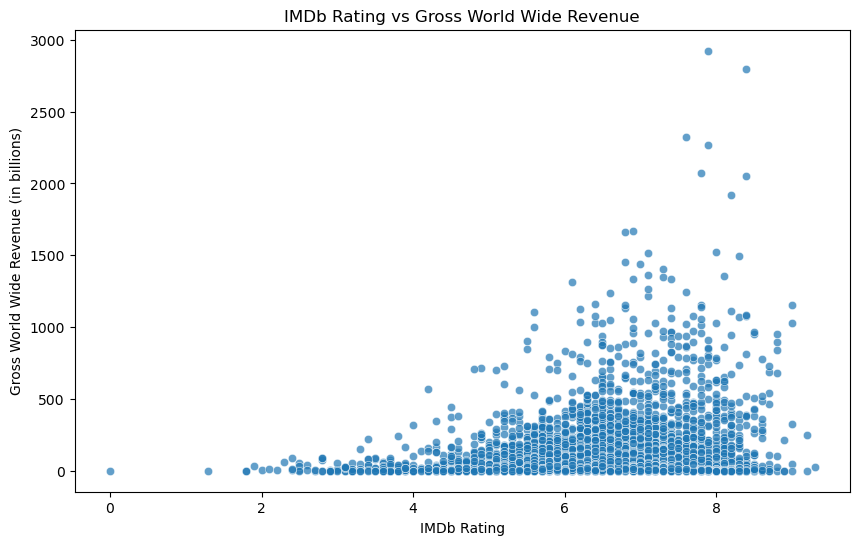

Correlation between IMDb Rating and Gross World Wide Revenue: 0.15


In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('normalized.db')

# Query to retrieve relevant data for analysis
query = '''
    SELECT
        Movie.Title,
        Movie.ImdbRating,
        Financials.GrossWorldWide
    FROM
        Movie
    LEFT JOIN Financials ON Movie.FinancialsId = Financials.FinancialsId
    WHERE
        Movie.ImdbRating IS NOT NULL
        AND Financials.GrossWorldWide IS NOT NULL
        AND Financials.GrossWorldWide != ''  -- Filter out empty values
'''

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Convert 'GrossWorldWide' column to numeric (ignoring errors, NaN for non-numeric values)
df['GrossWorldWide'] = pd.to_numeric(df['GrossWorldWide'], errors='coerce')

# Filter out rows with NaN values
df = df.dropna(subset=['GrossWorldWide'])

# Perform data analysis and visualization
# Scatter plot of IMDb Rating vs Gross World Wide Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ImdbRating', y='GrossWorldWide', data=df, alpha=0.7)
plt.title('IMDb Rating vs Gross World Wide Revenue')
plt.xlabel('IMDb Rating')
plt.ylabel('Gross World Wide Revenue (in billions)')
plt.show()

# Correlation analysis
correlation = df['ImdbRating'].corr(df['GrossWorldWide'])
print(f'Correlation between IMDb Rating and Gross World Wide Revenue: {correlation:.2f}')

### Correlation analysis between IMDb Rating and Gross World Wide Revenue:

The above code connects to an SQLite database, retrieves movie data including IMDb ratings and gross worldwide revenue, cleans the data, and generates a scatter plot using Matplotlib and Seaborn. 

The plot visualizes the correlation between IMDb ratings and gross worldwide revenue. 

Additionally, the code calculates and prints the correlation coefficient between these two variables.

In [8]:
# # Regression analysis (optional)
# #Uncomment the following lines if you want to perform a linear regression analysis
import statsmodels.api as sm
X = sm.add_constant(df['ImdbRating'])
model = sm.OLS(df['GrossWorldWide'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         GrossWorldWide   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     154.2
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           4.77e-35
Time:                        16:38:43   Log-Likelihood:                -47028.
No. Observations:                7128   AIC:                         9.406e+04
Df Residuals:                    7126   BIC:                         9.407e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -84.5920     13.986     -6.048      0.0

### Linear Regreassion Analysis:

"statsmodels" library sets up a simple linear regression model with IMDb ratings as the predictor variable and gross worldwide revenue as the response variable. 

The model is fitted to the data, and a summary is printed, providing detailed statistical information about the regression coefficients, significance levels, and goodness-of-fit measures. 

This analysis aims to quantify and understand the linear relationship between IMDb ratings and gross worldwide revenue in the movie dataset.

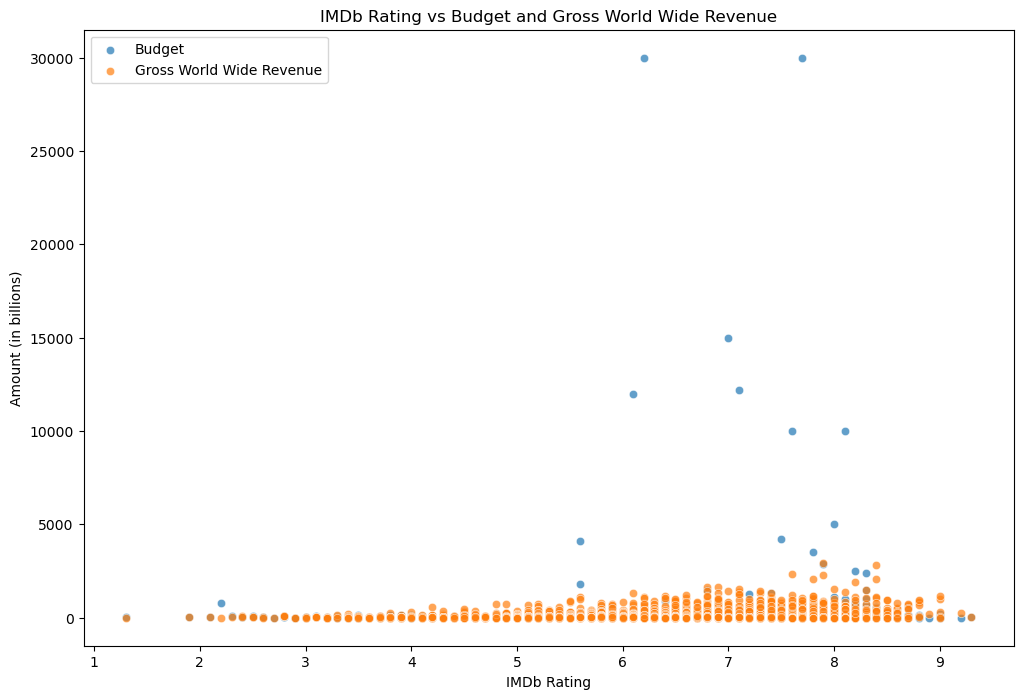

Correlation between IMDb Rating and Budget: 0.02
Correlation between IMDb Rating and Gross World Wide Revenue: 0.15

Regression Analysis for Budget:
                            OLS Regression Results                            
Dep. Variable:                 Budget   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.931
Date:                Sun, 17 Dec 2023   Prob (F-statistic):             0.0870
Time:                        16:38:52   Log-Likelihood:                -42463.
No. Observations:                5326   AIC:                         8.493e+04
Df Residuals:                    5324   BIC:                         8.494e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Connect to the SQLite database
conn = sqlite3.connect('normalized.db')

# Query to retrieve relevant data for analysis
query = '''
    SELECT
        Movie.Title,
        Movie.ImdbRating,
        Financials.Budget,
        Financials.GrossWorldWide
    FROM
        Movie
    LEFT JOIN Financials ON Movie.FinancialsId = Financials.FinancialsId
    WHERE
        Movie.ImdbRating IS NOT NULL
        AND Financials.Budget IS NOT NULL
        AND Financials.GrossWorldWide IS NOT NULL
'''

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Convert 'Budget' and 'GrossWorldWide' columns to numeric (ignoring errors, NaN for non-numeric values)
df['Budget'] = pd.to_numeric(df['Budget'], errors='coerce')
df['GrossWorldWide'] = pd.to_numeric(df['GrossWorldWide'], errors='coerce')

# Filter out rows with NaN values
df = df.dropna(subset=['Budget', 'GrossWorldWide'])

# Perform data analysis and visualization
# Scatter plot of IMDb Rating vs Budget and Gross World Wide Revenue
plt.figure(figsize=(12, 8))
sns.scatterplot(x='ImdbRating', y='Budget', data=df, alpha=0.7, label='Budget')
sns.scatterplot(x='ImdbRating', y='GrossWorldWide', data=df, alpha=0.7, label='Gross World Wide Revenue')
plt.title('IMDb Rating vs Budget and Gross World Wide Revenue')
plt.xlabel('IMDb Rating')
plt.ylabel('Amount (in billions)')
plt.legend()
plt.show()

# Correlation analysis
correlation_budget = df['ImdbRating'].corr(df['Budget'])
correlation_revenue = df['ImdbRating'].corr(df['GrossWorldWide'])

print(f'Correlation between IMDb Rating and Budget: {correlation_budget:.2f}')
print(f'Correlation between IMDb Rating and Gross World Wide Revenue: {correlation_revenue:.2f}')

# Regression analysis (optional)
X = sm.add_constant(df['ImdbRating'])
model_budget = sm.OLS(df['Budget'], X).fit()
model_revenue = sm.OLS(df['GrossWorldWide'], X).fit()

print("\nRegression Analysis for Budget:")
print(model_budget.summary())

print("\nRegression Analysis for Gross World Wide Revenue:")
print(model_revenue.summary())

### Data Analysis:

This Python code analyzes movie data from an SQLite database, specifically focusing on the relationships between IMDb ratings, budgets, and gross worldwide revenue. 

The code retrieves and cleans the data, creates a scatter plot to visually represent IMDb ratings against both budget and gross worldwide revenue, calculates correlation coefficients for these relationships, and optionally performs linear regression analysis. 

The analysis provides insights into the statistical relationships and regression models involving IMDb ratings, budgets, and revenue in the movie dataset.

In [11]:
import sqlite3
import pandas as pd
import statsmodels.api as sm

# Connect to the SQLite database
conn = sqlite3.connect('normalized.db')

# Query to retrieve relevant data for analysis
query = '''
    SELECT
        Movie.ImdbRating,
        Financials.Budget,
        Financials.GrossWorldWide
    FROM
        Movie
    LEFT JOIN Financials ON Movie.FinancialsId = Financials.FinancialsId
    WHERE
        Movie.ImdbRating IS NOT NULL
        AND Financials.Budget IS NOT NULL
        AND Financials.GrossWorldWide IS NOT NULL
        AND Financials.GrossWorldWide != ''
'''

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Convert 'GrossWorldWide' and 'Budget' columns to numeric
df['GrossWorldWide'] = pd.to_numeric(df['GrossWorldWide'], errors='coerce')
df['Budget'] = pd.to_numeric(df['Budget'], errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Define the independent variables (X) and the dependent variable (y)
X = df[['GrossWorldWide', 'Budget']]
y = df['ImdbRating']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())

# Close the database connection
conn.close()

                            OLS Regression Results                            
Dep. Variable:             ImdbRating   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     61.60
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           3.57e-27
Time:                        16:38:57   Log-Likelihood:                -7338.9
No. Observations:                5326   AIC:                         1.468e+04
Df Residuals:                    5323   BIC:                         1.470e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.5055      0.015    429.

### Data Analysis:

This Python code performs multiple linear regression analysis on movie data from an SQLite database. 

It retrieves IMDb ratings, budgets, and gross worldwide revenue from the 'Movie' and 'Financials' tables, cleans the data, and fits a multiple linear regression model using the statsmodels library. 

The regression model considers both budget and gross worldwide revenue as independent variables to predict IMDb ratings. 

The model summary includes statistical information about coefficients, standard errors, t-statistics, p-values, and goodness-of-fit measures. 

The analysis aims to understand the relationships and contributions of budget and revenue to the prediction of IMDb ratings in the movie dataset.

In [12]:
import sqlite3
import pandas as pd
import statsmodels.api as sm

# Connect to the SQLite database
conn = sqlite3.connect('normalized.db')

# Query to retrieve relevant data for analysis
query = '''
    SELECT
        Movie.ImdbRating,
        Movie.ReleaseYear,
        Movie.Runtime,
        Movie.NumberOfRatings,
        Financials.Budget,
        Financials.GrossUsCanada,
        Financials.GrossWorldWide
    FROM
        Movie
    LEFT JOIN Financials ON Movie.FinancialsId = Financials.FinancialsId
    WHERE
        Movie.ImdbRating IS NOT NULL
        AND Movie.ReleaseYear IS NOT NULL
        AND Movie.Runtime IS NOT NULL
        AND Movie.NumberOfRatings IS NOT NULL
        AND Financials.Budget IS NOT NULL
        AND Financials.GrossUsCanada IS NOT NULL
        AND Financials.GrossWorldWide IS NOT NULL
        AND Financials.GrossWorldWide != ''
'''

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Convert numeric columns to the appropriate data types
numeric_columns = ['ImdbRating', 'ReleaseYear', 'Runtime', 'NumberOfRatings', 'Budget', 'GrossUsCanada', 'GrossWorldWide']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Define the independent variables (X) and the dependent variable (y)
X = df[['ReleaseYear', 'Runtime', 'NumberOfRatings', 'Budget', 'GrossUsCanada', 'GrossWorldWide']]
y = df['ImdbRating']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())

# Close the database connection
conn.close()

                            OLS Regression Results                            
Dep. Variable:             ImdbRating   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     355.4
Date:                Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                        16:39:02   Log-Likelihood:                -5832.8
No. Observations:                4909   AIC:                         1.168e+04
Df Residuals:                    4902   BIC:                         1.173e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              30.8858      1.712     

This Python code conducts multiple linear regression analysis on movie data retrieved from an SQLite database. 

The analysis considers IMDb ratings as the dependent variable and includes independent variables such as release year, runtime, number of ratings, budget, gross US/Canada revenue, and gross worldwide revenue. 

The code cleans the data, converts numeric columns to appropriate data types, fits a multiple linear regression model using the statsmodels library, and prints a summary of the regression analysis. 

The model summary provides insights into the statistical significance and contribution of each variable to the prediction of IMDb ratings in the movie dataset.